In [56]:
!pip install --upgrade mxnet==1.6.0
!pip install gluonts

In [57]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from gluonts.mx.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
mpl.rcParams['figure.figsize']= (10,8)
mpl.rcParams['axes.grid'] = False

In [58]:
import pandas as pd
# Assuming your text file is named "data.txt" and is in the same directory as your Python script
file_path = "/content/51001h2022.txt"

# If your data is separated by spaces, you can use:
df = pd.read_csv(file_path, delim_whitespace=True)


<ipython-input-58-e33e348e29cb>:6: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, delim_whitespace=True)


In [59]:
df.head()

,#YY,MM,DD,hh,mm,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,TIDE
0,#yr,mo,dy,hr,mn,degT,m/s,m/s,m,sec,sec,degT,hPa,degC,degC,degC,mi,ft
1,2022,01,01,00,00,114,9.9,13.2,99.00,99.00,99.00,999,1006.2,23.4,24.2,23.1,99.0,99.00
2,2022,01,01,00,10,121,9.8,13.0,99.00,99.00,99.00,999,1005.6,23.5,24.2,23.3,99.0,99.00
3,2022,01,01,00,20,121,8.7,12.3,99.00,99.00,99.00,999,1005.4,23.6,24.2,23.1,99.0,99.00
4,2022,01,01,00,30,119,10.0,13.8,99.00,99.00,99.00,999,1005.5,23.6,24.2,23.4,99.0,99.00


In [60]:
#Remove the first row
df = df.iloc[1:]
df.head()

,#YY,MM,DD,hh,mm,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,TIDE
1,2022,01,01,00,00,114,9.9,13.2,99.00,99.00,99.00,999,1006.2,23.4,24.2,23.1,99.0,99.00
2,2022,01,01,00,10,121,9.8,13.0,99.00,99.00,99.00,999,1005.6,23.5,24.2,23.3,99.0,99.00
3,2022,01,01,00,20,121,8.7,12.3,99.00,99.00,99.00,999,1005.4,23.6,24.2,23.1,99.0,99.00
4,2022,01,01,00,30,119,10.0,13.8,99.00,99.00,99.00,999,1005.5,23.6,24.2,23.4,99.0,99.00
5,2022,01,01,00,40,118,10.1,13.6,4.13,10.00,7.46,93,1005.2,23.3,24.2,23.1,99.0,99.00


In [61]:
# Convert specific columns to numeric values
columns_to_convert = ['#YY', 'MM', 'DD', 'hh', 'mm', 'WDIR', 'WSPD', 'GST', 'WVHT', 'DPD', 'APD', 'MWD', 'PRES', 'ATMP', 'WTMP', 'DEWP', 'VIS', 'TIDE']
df[columns_to_convert] = df[columns_to_convert].apply(pd.to_numeric, errors='coerce')
# Alternatively, convert all object columns to numeric values
df = df.apply(pd.to_numeric, errors='coerce')

In [62]:
# Extract rows where mm=0
df = df[df["mm"] == 40]

In [63]:
#here we reset the index
df = df.reset_index(drop=True)

In [64]:
df.shape

(8747, 18)

In [65]:
df.isnull().sum()

#YY     0
MM      0
DD      0
hh      0
mm      0
WDIR    0
WSPD    0
GST     0
WVHT    0
DPD     0
APD     0
MWD     0
PRES    0
ATMP    0
WTMP    0
DEWP    0
VIS     0
TIDE    0
dtype: int64

In [66]:
df = df.dropna()

In [67]:
df.shape

(8747, 18)

In [68]:
#date and time columns into a single datetime column
df['date_time'] = pd.to_datetime(df[['#YY', 'MM', 'DD', 'hh', 'mm']].astype(str).apply(' '.join, axis=1), format='%Y %m %d %H %M')

In [69]:
# Drop 5 columns by specifying their column labels
columns_to_drop = ['#YY', 'MM', 'DD', 'hh', 'mm']
df = df.drop(columns=columns_to_drop)

In [70]:
# Move the 'date_time' column to the first position
date_time_column = df.pop('date_time')
df.insert(0, 'date_time', date_time_column)

In [71]:
df.head()

,date_time,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,TIDE
0,2022-01-01 00:40:00,118,10.1,13.6,4.13,10.00,7.46,93,1005.2,23.3,24.2,23.1,99.0,99.0
1,2022-01-01 01:40:00,127,6.5,8.6,4.27,10.00,7.67,80,1005.4,23.5,24.2,23.3,99.0,99.0
2,2022-01-01 02:40:00,148,5.9,8.0,4.10,9.09,7.75,102,1005.3,23.2,24.2,22.7,99.0,99.0
3,2022-01-01 03:40:00,149,5.9,7.8,3.73,10.00,7.58,84,1005.6,22.7,24.2,22.3,99.0,99.0
4,2022-01-01 04:40:00,139,7.0,9.4,3.20,10.00,7.28,80,1006.1,23.2,24.2,22.6,99.0,99.0


In [72]:
unique_values = df['WVHT'].unique()
unique_values

array([ 4.13,  4.27,  4.1 ,  3.73,  3.2 ,  3.68,  4.23,  4.07,  3.94,
        3.51,  3.59,  3.56,  3.18,  3.55,  3.19,  3.37,  3.01,  3.26,
        3.17,  3.11,  3.3 ,  3.34,  3.62,  3.84,  3.21,  3.23,  3.39,
        3.28,  3.12,  3.08,  2.91,  3.4 ,  3.32,  3.04,  2.98,  2.99,
        3.02,  2.8 ,  2.7 ,  2.66,  2.73,  2.62,  2.74,  2.75,  2.58,
        2.61,  2.59,  2.72,  2.51,  2.37,  2.02,  2.31,  2.26,  2.38,
        2.39,  2.15,  2.11,  2.21,  2.14,  1.97,  1.93,  1.76,  1.9 ,
        1.88,  1.99,  1.98,  2.05,  2.12,  1.91,  1.85,  1.92,  1.72,
        1.86,  1.67,  1.95,  1.73,  1.68,  1.71,  1.79,  1.7 ,  1.81,
        1.89,  2.18,  2.36,  2.34,  2.29,  2.2 ,  2.42,  2.57,  2.93,
        3.  ,  2.97,  3.44,  3.27,  4.84,  3.81,  3.72,  3.99,  3.53,
        3.76,  3.95,  3.96,  4.21,  5.  ,  4.12,  4.04,  4.52,  4.01,
        4.02,  3.67,  4.09,  3.49,  3.58,  3.54,  3.63,  3.52,  3.43,
        3.05,  2.95,  3.09,  2.83,  3.15,  2.65,  3.22,  2.6 ,  2.54,
        2.56,  2.32,

In [73]:
df = df[df['WVHT'] != 99]

In [74]:
df.shape

(8548, 14)

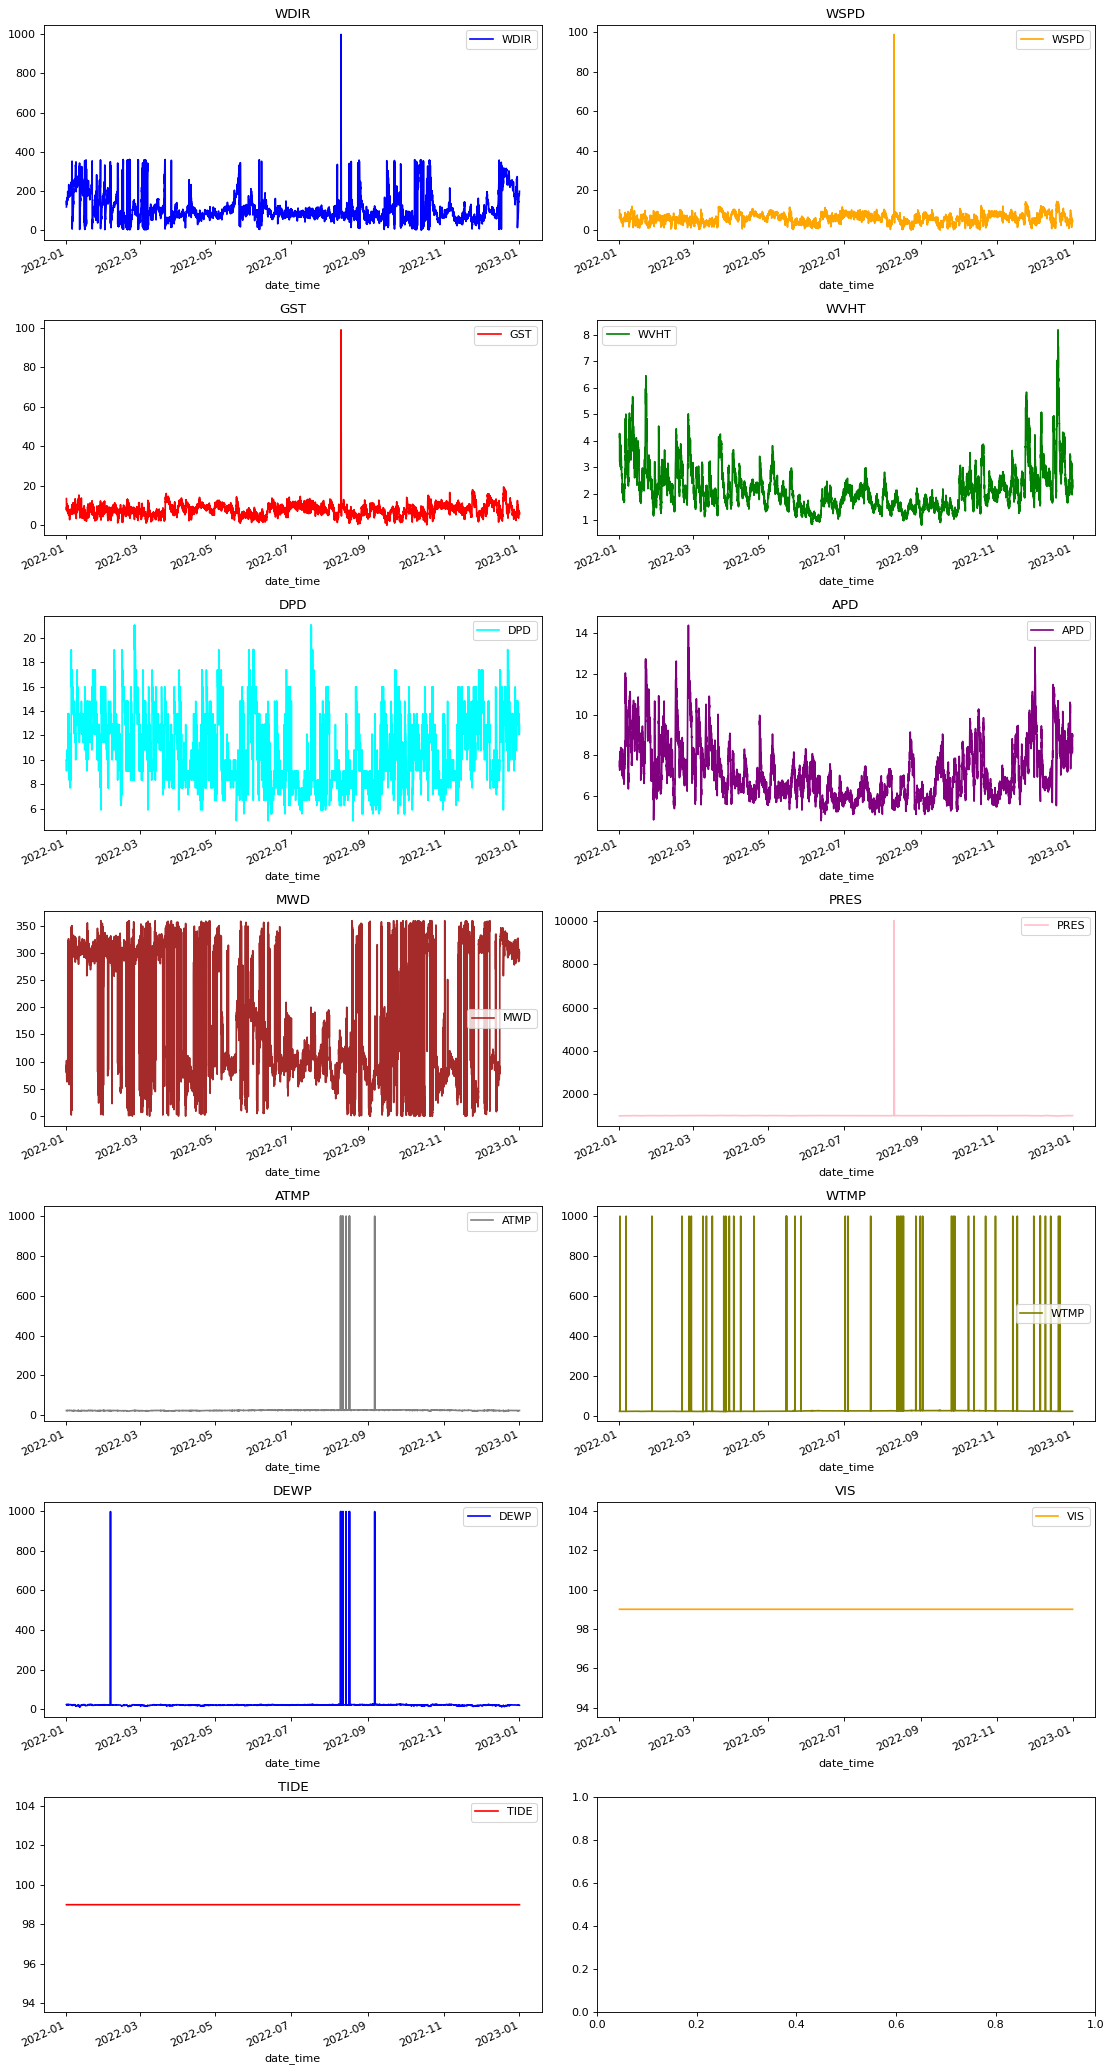

In [75]:
color_list = ["blue", "orange", "red", "green", "cyan", "purple", "brown", "pink", "gray", "olive"]
date_key = "date_time"

def Visualize(data):
    time_data = data[date_key]
    features = list(data.select_dtypes(include=[np.number]).columns.values)
    feature_size = len(features)
    fig, axes = plt.subplots(nrows=int(np.ceil(feature_size / 2)), ncols=2, figsize=(14, feature_size * 2), dpi=80, facecolor="w", edgecolor="k")

    for i in range(feature_size):
        key = features[i]
        c = color_list[i % len(color_list)]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(ax=axes[i // 2, i % 2], color=c, title="{}".format(key), rot=25,)
        ax.legend([key])

    plt.tight_layout()

# Assuming you have a DataFrame named 'df', pass it to the Visualize function.
Visualize(df)

In [76]:
df = df.set_index("date_time")

In [77]:
df.head()

,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,TIDE
date_time,,,,,,,,,,,,,
2022-01-01 00:40:00,118,10.1,13.6,4.13,10.00,7.46,93,1005.2,23.3,24.2,23.1,99.0,99.0
2022-01-01 01:40:00,127,6.5,8.6,4.27,10.00,7.67,80,1005.4,23.5,24.2,23.3,99.0,99.0
2022-01-01 02:40:00,148,5.9,8.0,4.10,9.09,7.75,102,1005.3,23.2,24.2,22.7,99.0,99.0
2022-01-01 03:40:00,149,5.9,7.8,3.73,10.00,7.58,84,1005.6,22.7,24.2,22.3,99.0,99.0
2022-01-01 04:40:00,139,7.0,9.4,3.20,10.00,7.28,80,1006.1,23.2,24.2,22.6,99.0,99.0


In [78]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Display the correlation matrix
print(correlation_matrix)

          WDIR      WSPD       GST      WVHT       DPD       APD       MWD  \
WDIR  1.000000 -0.107385 -0.085191  0.204160  0.175333  0.306313  0.207019   
WSPD -0.107385  1.000000  0.983162  0.322081 -0.128765 -0.318178 -0.100472   
GST  -0.085191  0.983162  1.000000  0.408880 -0.094020 -0.249083 -0.064636   
WVHT  0.204160  0.322081  0.408880  1.000000  0.388666  0.644884  0.340345   
DPD   0.175333 -0.128765 -0.094020  0.388666  1.000000  0.626332  0.609028   
APD   0.306313 -0.318178 -0.249083  0.644884  0.626332  1.000000  0.520452   
MWD   0.207019 -0.100472 -0.064636  0.340345  0.609028  0.520452  1.000000   
PRES  0.117270  0.401017  0.344302 -0.013862 -0.015594 -0.018693 -0.010518   
ATMP  0.025916  0.117513  0.094785 -0.052335 -0.041759 -0.048263 -0.033993   
WTMP -0.001852 -0.007985 -0.008449 -0.010220 -0.015657 -0.003104 -0.022800   
DEWP  0.023759  0.108448  0.086970 -0.044324 -0.028601 -0.031193 -0.020568   
VIS        NaN       NaN       NaN       NaN       NaN       NaN

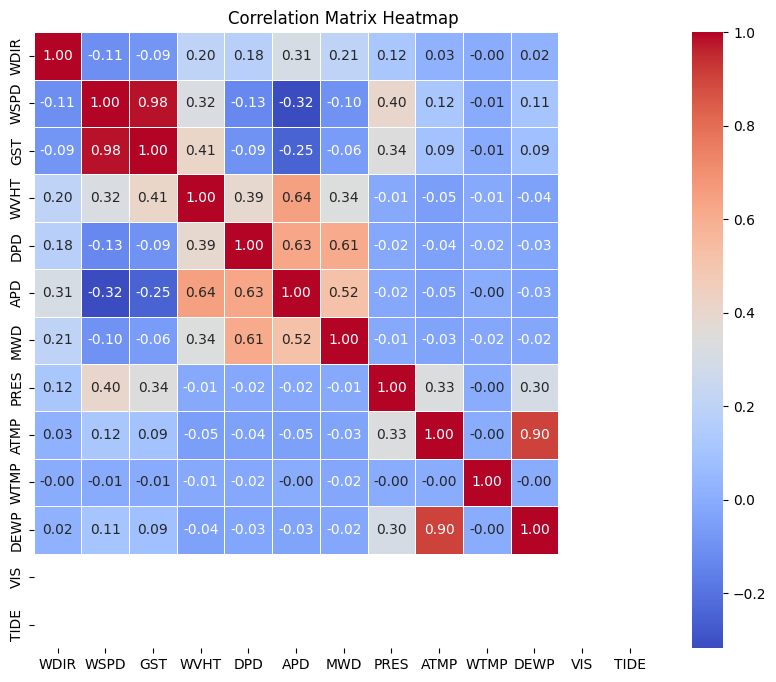

In [79]:
import seaborn as sns
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [80]:
train_time = "2022-11-01 00:40:00"
prediction_length = 24

In [81]:
estimator = DeepAREstimator(
    prediction_length=prediction_length,
    freq="1H",
    context_length=240,
    num_layers=2,
    num_cells=128,
    cell_type='lstm',
    scaling=True,
    dropout_rate=0.8,
    trainer=Trainer(
        learning_rate=1e-3,
        epochs=20,
    ),
)

In [82]:
estimator

gluonts.mx.model.deepar._estimator.DeepAREstimator(alpha=0.0, batch_size=32, beta=0.0, cardinality=None, cell_type='lstm', context_length=240, default_scale=None, distr_output=gluonts.mx.distribution.student_t.StudentTOutput(), dropout_rate=0.8, dropoutcell_type='ZoneoutCell', dtype=<class 'numpy.float32'>, embedding_dimension=None, freq='1H', imputation_method=None, impute_missing_values=False, lags_seq=None, minimum_scale=1e-10, num_cells=128, num_imputation_samples=1, num_layers=2, num_parallel_samples=100, prediction_length=24, scaling=True, time_features=None, train_sampler=None, trainer=gluonts.mx.trainer._base.Trainer(add_default_callbacks=True, callbacks=None, clip_gradient=10.0, ctx=None, epochs=20, hybridize=True, init='xavier', learning_rate=0.001, num_batches_per_epoch=50, weight_decay=1e-08), use_feat_dynamic_real=False, use_feat_static_cat=False, use_feat_static_real=False, validation_sampler=None)

In [83]:
from gluonts.dataset.common import ListDataset
training_data = ListDataset([{"start":df.index[0], "target":df.WVHT[:train_time]}], freq="1H")

In [84]:
# Train the model
predictor = estimator.train(training_data=training_data)

100%|██████████| 50/50 [01:20<00:00,  1.61s/it, epoch=20/20, avg_epoch_loss=-.683]


In [85]:
test_data = ListDataset(
    [
      {"start":df.index[0], "target":df.WVHT[:"2022-11-02 00:40:00"]},
      {"start":df.index[0], "target":df.WVHT[:"2022-11-12 00:40:00"]}
    ],
    freq="1H"
)

In [86]:
from gluonts.evaluation.backtest import make_evaluation_predictions

In [87]:
# Make predictions
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data,
    predictor=predictor,
    num_samples=100,
)

In [88]:
forecasts = list(forecast_it)
tss = list(ts_it)

In [89]:
'''
import matplotlib.pyplot as plt

def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = prediction_length
    prediction_intervals = [10.0, 90.0]
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()
'''

'\nimport matplotlib.pyplot as plt\n\ndef plot_prob_forecasts(ts_entry, forecast_entry):\n    plot_length = prediction_length\n    prediction_intervals = [10.0, 90.0]\n    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]\n    fig, ax = plt.subplots(1, 1, figsize=(10, 7))\n    ts_entry[-plot_length:].plot(ax=ax)\n    forecast_entry.plot(prediction_intervals=prediction_intervals, color=\'g\')\n    plt.grid(which="both")\n    plt.legend(legend, loc="upper left")\n    plt.show()\n'

In [90]:
#plot_prob_forecasts(tss[0], forecasts[0])
#plot_prob_forecasts(tss[1], forecasts[1])

In [133]:
# first entry of the time series list
ts_entry = tss[0]

In [134]:
ts_entry

,0
2022-01-01 00:00,4.13
2022-01-01 01:00,4.27
2022-01-01 02:00,4.10
2022-01-01 03:00,3.73
2022-01-01 04:00,3.20
...,...
2022-10-25 01:00,1.99
2022-10-25 02:00,2.01
2022-10-25 03:00,2.05
2022-10-25 04:00,1.94


In [135]:
# first 5 values of the time series (convert from pandas to numpy)
np.array(ts_entry[:5]).reshape(
    -1,
)

array([4.13, 4.27, 4.1 , 3.73, 3.2 ], dtype=float32)

In [136]:
# first entry of test_ds
test_ds_entry = next(iter(test_data ))

In [137]:
test_ds_entry

{'start': Period('2022-01-01 00:00', 'H'),
 'target': array([4.13, 4.27, 4.1 , ..., 2.05, 1.94, 2.  ], dtype=float32)}

In [138]:
# first 5 values
test_ds_entry["target"][:5]

array([4.13, 4.27, 4.1 , 3.73, 3.2 ], dtype=float32)

In [139]:
# first entry of the forecast list
forecast_entry = forecasts[0]

In [140]:
forecast_entry

gluonts.model.forecast.SampleForecast(info=None, item_id=None, samples=array([[1.807635 , 1.7636942, 1.772643 , ..., 1.8885502, 1.9067599,
        1.8469937],
       [1.8661269, 1.7323927, 1.646897 , ..., 1.8121659, 1.8202753,
        1.8117745],
       [1.8079659, 1.9184232, 1.7923441, ..., 1.96424  , 1.9009086,
        1.8537546],
       ...,
       [1.9769096, 1.9784542, 1.9190701, ..., 1.8546113, 1.8977259,
        1.7419016],
       [1.8619313, 1.9573432, 1.9479982, ..., 1.7575264, 1.7892073,
        1.744108 ],
       [1.9133787, 2.075678 , 2.0241342, ..., 1.8150636, 1.7729204,
        1.8463755]], dtype=float32), start_date=Period('2022-10-24 06:00', 'H'))

In [141]:
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 100
Dimension of samples: (100, 24)
Start date of the forecast window: 2022-10-24 06:00
Frequency of the time series: <Hour>


In [142]:
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")
print(f"0.1-quantile (median) of the future window:\n {forecast_entry.quantile(0.1)}")
print(f"0.9-quantile (median) of the future window:\n {forecast_entry.quantile(0.9)}")

Mean of the future window:
 [1.8593045 1.8709172 1.8499947 1.8753253 1.8704958 1.8601484 1.8517652
 1.8369175 1.8392105 1.8699178 1.8542719 1.8546618 1.8242034 1.8150862
 1.8024182 1.825647  1.802621  1.7818954 1.8008475 1.807922  1.8095818
 1.800742  1.8015993 1.774806 ]
0.5-quantile (median) of the future window:
 [1.8824157 1.8829461 1.8516762 1.8619856 1.8653135 1.8723506 1.8451161
 1.8386997 1.8469658 1.8690789 1.8664008 1.8443407 1.8199308 1.8026965
 1.7897863 1.820359  1.8109353 1.7704322 1.8005021 1.8023949 1.811136
 1.8094797 1.8032845 1.7828147]
0.1-quantile (median) of the future window:
 [1.7441132 1.7283607 1.7100258 1.6954501 1.6770091 1.6582606 1.6500714
 1.6237241 1.6444436 1.6683283 1.6691426 1.6512874 1.6227165 1.6106497
 1.6212159 1.6298314 1.60677   1.5737147 1.5630983 1.549368  1.6286986
 1.5963727 1.6043425 1.541079 ]
0.9-quantile (median) of the future window:
 [1.9554058 2.0143583 1.9788148 2.03868   2.0515075 2.0403929 2.0676384
 2.0176275 2.0229576 2.0765018 2

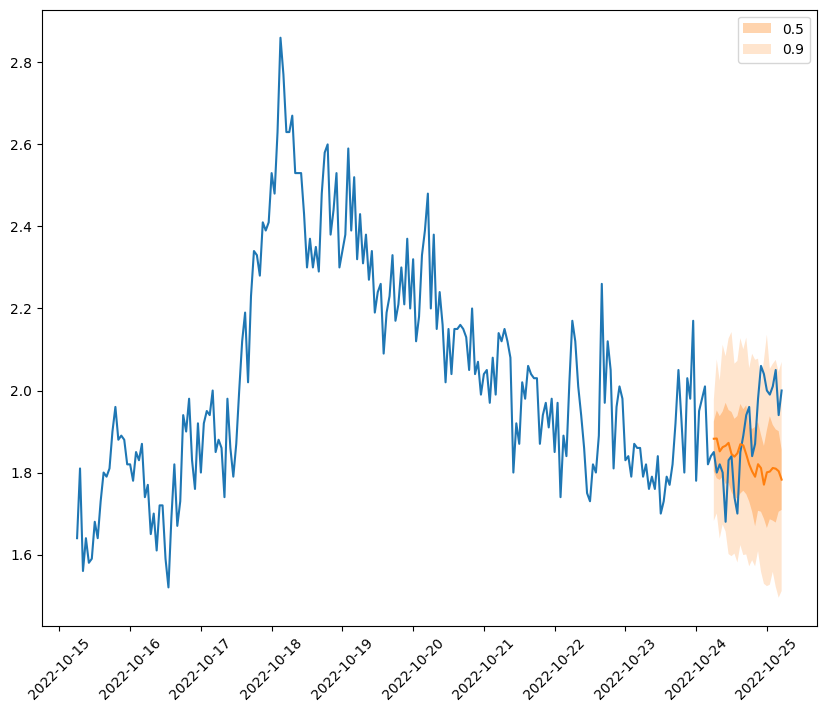

In [143]:
import matplotlib.pyplot as plt

plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.plot(ts_entry[-240:].to_timestamp())
forecast_entry.plot(show_label=True)
plt.legend()

# Save the figure as a PNG file
plt.savefig("deep_ar.png", format="png")

# Show the plot (optional)
plt.show()

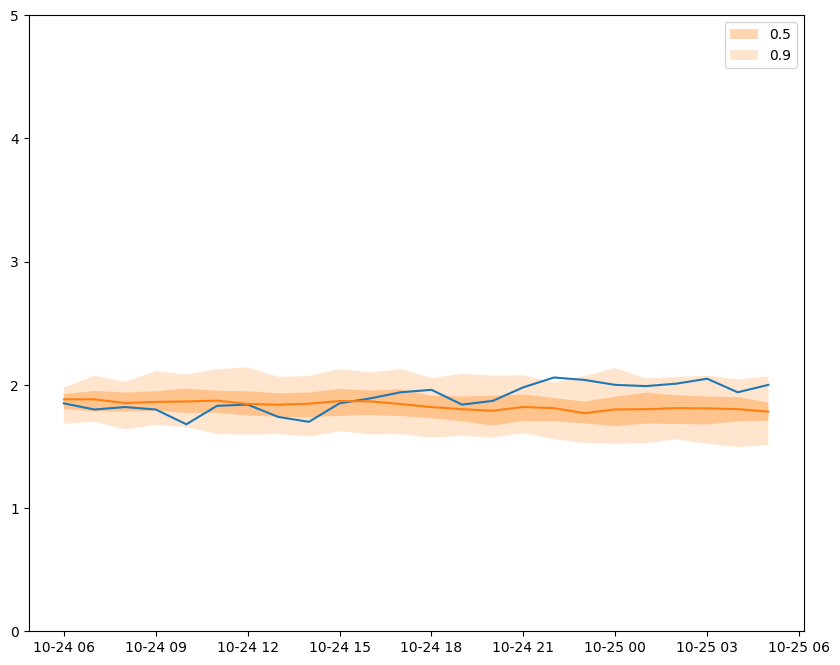

In [144]:
import matplotlib.pyplot as plt

# Set the desired y-axis limits
y_min = 0
y_max = 5
plot_length = prediction_length
# Plot the time series and forecast with custom y-axis limits
plt.plot(ts_entry[-plot_length:].to_timestamp())
forecast_entry.plot(show_label=True)
plt.legend()

# Set the y-axis limits
plt.ylim(y_min, y_max)

# Save the figure as a PNG file
plt.savefig("deep_ar_closer.png", format="png")

# Show the plot
plt.show()


In [145]:
from gluonts.evaluation import Evaluator

In [146]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(tss, forecasts)

Running evaluation: 2it [00:00, 33.12it/s]


In [147]:
import json
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 0.01729092188179493,
    "abs_error": 5.171630382537842,
    "abs_target_sum": 91.2800064086914,
    "abs_target_mean": 1.901666800181071,
    "seasonal_error": 0.40384762821648634,
    "MASE": 0.26652740382561413,
    "MAPE": 0.05636417120695114,
    "sMAPE": 0.057309272388617195,
    "MSIS": 1.6477884994122038,
    "QuantileLoss[0.1]": 2.4746974229812624,
    "Coverage[0.1]": 0.020833333333333332,
    "QuantileLoss[0.5]": 5.171630382537842,
    "Coverage[0.5]": 0.39583333333333337,
    "QuantileLoss[0.9]": 2.1663055658340453,
    "Coverage[0.9]": 0.8541666666666666,
    "RMSE": 0.1314949500239265,
    "NRMSE": 0.069147208128893,
    "ND": 0.0566567705898563,
    "wQuantileLoss[0.1]": 0.02711105663053097,
    "wQuantileLoss[0.5]": 0.0566567705898563,
    "wQuantileLoss[0.9]": 0.02373253082536787,
    "mean_absolute_QuantileLoss": 3.2708777904510495,
    "mean_wQuantileLoss": 0.03583345268191838,
    "MAE_Coverage": 0.38472222222222224,
    "OWA": NaN
}


In [148]:
item_metrics.head()

,item_id,forecast_start,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,ND,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,None,2022-10-24 06:00,0.021335,2.942055,45.480003,1.895000,0.406894,0.301272,0.063526,0.065344,0.064689,1.474436,1.242385,0.000000,2.942055,0.416667,1.102075,0.791667
1,None,2022-11-03 05:00,0.013247,2.229576,45.800003,1.908333,0.400801,0.231783,0.049203,0.049274,0.048681,1.821141,1.232312,0.041667,2.229576,0.375000,1.064231,0.916667


In [149]:
import numpy as np

# Define the quantiles for prediction intervals
quantiles = [0.1, 0.5, 0.9]

# Initialize variables to store PICP and MPIW
picp_values = []
mpiw_values = []

# Iterate through the forecasts and true target values
for forecast, ts in zip(forecasts, tss):
    # Extract the true target values
    actual_values = ts.values[-prediction_length:]

    # Initialize a list to store PICP values for each quantile
    picp_quantile = []

    # Calculate the lower and upper quantiles
    lower_quantiles = [forecast.quantile(q) for q in quantiles]
    upper_quantiles = [forecast.quantile(1 - q) for q in quantiles]

    # Check PICP for each quantile
    for i in range(prediction_length):
        if lower_quantiles[0][i] <= actual_values[i] <= upper_quantiles[0][i]:
            picp_quantile.append(1)
        else:
            picp_quantile.append(0)

    # Calculate PICP for this forecast as a percentage
    picp = np.mean(picp_quantile) * 100

    # Calculate MPIW
    mpiw = np.mean([upper - lower for lower, upper in zip(lower_quantiles[0], upper_quantiles[0])])

    # Append PICP and MPIW values to the respective lists
    picp_values.append(picp)
    mpiw_values.append(mpiw)

# Calculate the overall PICP and MPIW
overall_picp = np.mean(picp_values)
overall_mpiw = np.mean(mpiw_values)

# Print the results
print(f"Overall PICP (%): {overall_picp:.4f}%")
print(f"Overall MPIW: {overall_mpiw:.4f}")


Overall PICP (%): 83.3333%
Overall MPIW: 0.3869
